In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import torchvision as tv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Работа с данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Краткий анализ

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

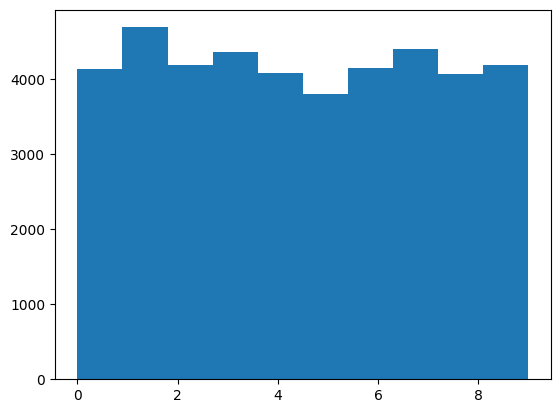

In [ ]:
plt.hist(df['label'], bins = 10)

### Dataset и Dataloader

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32)

In [ ]:
ds.shape

torch.Size([42000, 785])

In [ ]:
# ds = ds.view

In [ ]:
border = int(0.8*len(ds[:,0])) #для разделения на тренировочный и валидационный датасеты
print(border)
X = ds[:border,1:]/255 # нормализованный тензор значений пикселей
X = torch.tensor(X).reshape(-1, 1, 28, 28)
y = ds[:border,0]
train_dataset = torch.utils.data.TensorDataset(X, y) #создание датасета
print(X.shape)
print(y.shape)

33600
torch.Size([33600, 1, 28, 28])
torch.Size([33600])


<ipython-input-5-b2ef5eab1320>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(-1, 1, 28, 28)


In [ ]:
X = ds[border:,1:]/255 # нормализованный тензор значений пикселей
X = torch.tensor(X).reshape(-1, 1, 28, 28)
y = ds[border:,0]
val_dataset = torch.utils.data.TensorDataset(X, y)
print(X.shape)
print(y.shape)

torch.Size([8400, 1, 28, 28])
torch.Size([8400])


<ipython-input-6-0d709e3bc610>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(-1, 1, 28, 28)


#### Визуализация данных из  тензора и датасета

In [ ]:
ds[0, 1:].numpy().reshape(28,28).shape

(28, 28)

tensor(3.)


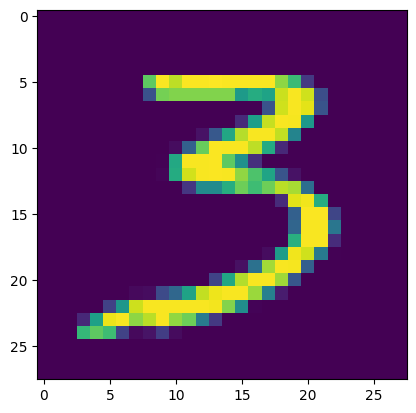

In [ ]:
plt.imshow(ds[25, 1:].numpy().reshape(28,28))
print(ds[25,0])

tensor(3.)


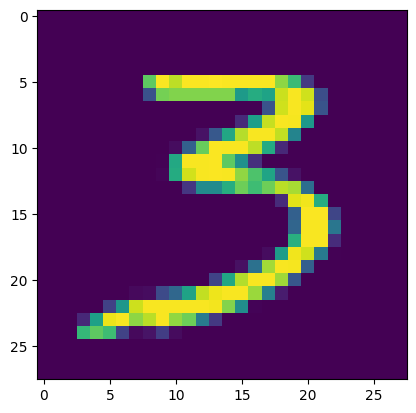

In [ ]:
plt.imshow(train_dataset[25][0].numpy().reshape(28,28))
print(train_dataset[25][1])

#### Создание загрузчика данных

In [ ]:
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
for digit, label in train_dataloader:
  print(digit.shape)
  print(label.shape)
  break


torch.Size([10, 1, 28, 28])
torch.Size([10])


In [ ]:
label[0]

tensor(2.)

# Нейронная сеть

### Загрузка стандартного датасета - нужно было для проверки

In [ ]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

In [ ]:
train_mnist = tv.datasets.MNIST('data_mnist/train', download=True, transform=trans)
test_mnist = tv.datasets.MNIST('data_mnist/test', download=True, transform=trans)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37533977.48it/s]


Extracting data_mnist/train/MNIST/raw/train-images-idx3-ubyte.gz to data_mnist/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1117333.34it/s]


Extracting data_mnist/train/MNIST/raw/train-labels-idx1-ubyte.gz to data_mnist/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9244089.22it/s]


Extracting data_mnist/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data_mnist/train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6042032.59it/s]

Extracting data_mnist/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_mnist/train/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33384545.84it/s]


Extracting data_mnist/test/MNIST/raw/train-images-idx3-ubyte.gz to data_mnist/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1226218.71it/s]


Extracting data_mnist/test/MNIST/raw/train-labels-idx1-ubyte.gz to data_mnist/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9232710.95it/s]


Extracting data_mnist/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data_mnist/test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1571955.51it/s]

Extracting data_mnist/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_mnist/test/MNIST/raw



In [ ]:
len(train_mnist)

60000

In [ ]:
len(test_mnist)

60000

In [ ]:

# batch_size = 16
# dataloader = torch.utils.data.DataLoader(
#     ds_mnist, batch_size=batch_size, shuffle=True,
#     num_workers=1, drop_last=True
# )

batch_size = 50
train_dataloader = torch.utils.data.DataLoader(train_mnist, batch_size=batch_size, shuffle=True, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(test_mnist, batch_size=batch_size)

In [ ]:
for img, label in train_dataloader:
  print(img.shape)
  print(label.shape)
  break

torch.Size([10, 1, 28, 28])
torch.Size([10])


###Модель

In [ ]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
# device  = "cpu"
device

'cuda'

In [ ]:
class MyConvDigitRecognizer(nn.Module):
  def __init__(self, n):
    super().__init__()  # batch, 1, 28, 28
    # id_channels - каналы фотографии, out_channels - фильтры, kernel_size - размер окна, padding - срезание по краям
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels=5, kernel_size=3, stride=1, padding=1) # batch, 5, 28, 28
    self.bn1 = nn.BatchNorm2d(5)
    self.act_fn1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # batch, 5, 14, 14

    self.conv2 = nn.Conv2d(in_channels = 5, out_channels=10, kernel_size=3, stride=1, padding=1) # batch, 10, 14, 14
    self.bn2 = nn.BatchNorm2d(10)
    self.act_fn2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # batch, 10, 7, 7

    self.conv3 = nn.Conv2d(in_channels = 10, out_channels=15, kernel_size=3, stride=1, padding=1) # batch, 15, 7, 7
    self.bn3 = nn.BatchNorm2d(15)
    self.act_fn3 = nn.ReLU()

    self.l1 = nn.Linear(735, n)
    self.l1_act = nn.ReLU()
    self.l2 = nn.Linear(n, 10)

  def forward(self, x):
    x = self.bn1(self.conv1(x))
    x = self.act_fn1(x)
    x = self.pool1(x)

    x = self.bn2(self.conv2(x))
    x = self.act_fn2(x)
    x = self.pool2(x)

    x = self.bn3(self.conv3(x))
    x = self.act_fn3(x)

    x = x.view(-1,15*7*7)
    x = self.l1 (x)
    x = self.l1_act(x)
    x = self.l2(x)

    return x

In [ ]:
n = 100
model = MyConvDigitRecognizer(n)

In [ ]:
# функция потерь

loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# model.parameters - веса и смещения модели
# momentum - чтобы не застревать в локальных минимумах

In [ ]:
def accuracy (prediction, label):
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  # равны ли индексы максимальных элементов
  # print(answer)
  # print(answer.sum())
  return answer.mean()

### Обучение

In [ ]:
import time

max_acc = 0
model = model.to(device)
loss_fn = loss_fn.to(device)

epochs = 20
start_time = time.time()
for e in range(epochs):

  model.train()

  loss_train = 0
  acc_train = 0

  for digit, label in tqdm(train_dataloader):
    optimizer.zero_grad()

    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    # digit = digit.views(-1, 28*28)

    prediction = model(digit)

    loss = loss_fn(prediction, label)
    loss.backward() #подсчёт градиентов
    loss_train += loss.item()

    optimizer.step()

    acc_train += accuracy(prediction.cpu(), label.cpu())

  # Валидация модели после обучения на каждой эпохе
  acc_val = 0

  model.eval()

  for digit, label in val_dataloader:
      digit = digit.to(device)
      label = label.to(device)

      # превращение label в вектор вероятностей (3 -> 00010000000)
      label = label.long() # так как аргумент one_hot должен быть целым
      label = F.one_hot(label, 10).float()

      prediction = model(digit)

      acc_val += accuracy(prediction.cpu(), label.cpu())

  if (acc_val/len(val_dataloader)) > max_acc:
      print("-------------Сохраниение модели-------------")
      max_acc = acc_val/len(val_dataloader)
      torch.save(model, '/content/drive/MyDrive/Colab Notebooks/УИРС/conv_mnist_model.pth')

  print(f'epoch: {e}, looss: {loss_train/len(train_dataloader)}, accuracy: {acc_train/len(train_dataloader)}')
  print(f'Accuracy val: {acc_val/len(val_dataloader)}')
end_time = time.time()
print("Время обучения:", end_time - start_time)

  0%|          | 0/3360 [00:00<?, ?it/s]<ipython-input-63-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 3360/3360 [00:11<00:00, 288.15it/s]


-------------Сохраниение модели-------------
epoch: 0, looss: 0.2526302719539325, accuracy: 0.9316071428571572
Accuracy val: 0.9759523809523777


100%|██████████| 3360/3360 [00:12<00:00, 269.94it/s]


-------------Сохраниение модели-------------
epoch: 1, looss: 0.07546826765567294, accuracy: 0.9776785714285818
Accuracy val: 0.976547619047616


100%|██████████| 3360/3360 [00:11<00:00, 282.97it/s]


-------------Сохраниение модели-------------
epoch: 2, looss: 0.05715596126833805, accuracy: 0.9818750000000093
Accuracy val: 0.9841666666666643


100%|██████████| 3360/3360 [00:11<00:00, 287.61it/s]


-------------Сохраниение модели-------------
epoch: 3, looss: 0.04713402673446147, accuracy: 0.9847916666666748
Accuracy val: 0.9858333333333312


100%|██████████| 3360/3360 [00:11<00:00, 289.55it/s]


epoch: 4, looss: 0.03895919862090328, accuracy: 0.9879464285714359
Accuracy val: 0.9835714285714261


100%|██████████| 3360/3360 [00:11<00:00, 290.30it/s]


-------------Сохраниение модели-------------
epoch: 5, looss: 0.035047212590450814, accuracy: 0.9884226190476255
Accuracy val: 0.9861904761904742


100%|██████████| 3360/3360 [00:11<00:00, 296.01it/s]


-------------Сохраниение модели-------------
epoch: 6, looss: 0.02961709752785607, accuracy: 0.9904761904761954
Accuracy val: 0.986785714285712


100%|██████████| 3360/3360 [00:11<00:00, 281.63it/s]


epoch: 7, looss: 0.02751662109455559, accuracy: 0.9912202380952427
Accuracy val: 0.9857142857142835


100%|██████████| 3360/3360 [00:11<00:00, 300.72it/s]


epoch: 8, looss: 0.023906865597328554, accuracy: 0.9925595238095284
Accuracy val: 0.986785714285712


100%|██████████| 3360/3360 [00:11<00:00, 302.29it/s]


-------------Сохраниение модели-------------
epoch: 9, looss: 0.02115194312774574, accuracy: 0.9930357142857185
Accuracy val: 0.9872619047619027


100%|██████████| 3360/3360 [00:11<00:00, 300.71it/s]


-------------Сохраниение модели-------------
epoch: 10, looss: 0.019262528354801134, accuracy: 0.9942261904761939
Accuracy val: 0.9876190476190457


100%|██████████| 3360/3360 [00:11<00:00, 296.60it/s]


epoch: 11, looss: 0.017470826483557425, accuracy: 0.9945833333333369
Accuracy val: 0.9873809523809505


100%|██████████| 3360/3360 [00:11<00:00, 285.70it/s]


epoch: 12, looss: 0.015082202073901757, accuracy: 0.9956547619047645
Accuracy val: 0.9873809523809504


100%|██████████| 3360/3360 [00:11<00:00, 282.40it/s]


epoch: 13, looss: 0.013169059600797828, accuracy: 0.9964285714285736
Accuracy val: 0.9865476190476171


100%|██████████| 3360/3360 [00:11<00:00, 288.49it/s]


epoch: 14, looss: 0.012249564109753629, accuracy: 0.9963392857142879
Accuracy val: 0.986190476190474


100%|██████████| 3360/3360 [00:11<00:00, 289.99it/s]


-------------Сохраниение модели-------------
epoch: 15, looss: 0.011163813487443603, accuracy: 0.9966666666666685
Accuracy val: 0.9883333333333316


100%|██████████| 3360/3360 [00:11<00:00, 286.48it/s]


epoch: 16, looss: 0.009956082956024287, accuracy: 0.9971726190476206
Accuracy val: 0.9882142857142837


100%|██████████| 3360/3360 [00:11<00:00, 292.83it/s]


-------------Сохраниение модели-------------
epoch: 17, looss: 0.009430102993007628, accuracy: 0.9971428571428588
Accuracy val: 0.988452380952379


100%|██████████| 3360/3360 [00:11<00:00, 288.56it/s]


epoch: 18, looss: 0.008398933126720338, accuracy: 0.9977380952380966
Accuracy val: 0.9877380952380933


100%|██████████| 3360/3360 [00:11<00:00, 287.50it/s]


epoch: 19, looss: 0.00732982058043236, accuracy: 0.9980059523809535
Accuracy val: 0.9878571428571409
Время обучения: 256.1231062412262


CPU - 10 эпох - 349 сек - 0.987 (batch=10)<br>
cuda - 10 эпох - 129 сек - 0.987 (batch=10)<br>
<br>
cuda - 20 эпох - 179 сек - 0.989 (batch=15)<br>
cuda - 40 эпох - 359 сек - 0.988.8 (batch=15)<br>

cuda - 20 эпох - 256 сек - 0.988.8 (batch=10)<br>

In [ ]:
# Загрузка весов сохраённой модели
weights = torch.load('/content/drive/MyDrive/Colab Notebooks/УИРС/conv_mnist_model.pth')
model.load_state_dict(weights.state_dict())

<All keys matched successfully>

### Валидация

In [ ]:
acc_val = 0

model.eval()

for digit, label in val_dataloader:
    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    acc_val += accuracy(prediction.cpu(), label.cpu())

print(f'accuracy: {acc_val/len(val_dataloader)}')

<ipython-input-63-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)


accuracy: 0.988452380952379


# Формирование  сабмита

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_test.csv')

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32) / 255.0
# нормализованный тензор значений пикселей

ds.shape

torch.Size([28000, 784])

In [ ]:
ds = torch.tensor(ds).reshape(-1, 1, 28, 28)

<ipython-input-32-2cb103405157>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.tensor(ds).reshape(-1, 1, 28, 28)


In [ ]:
ds.shape

torch.Size([28000, 1, 28, 28])

In [ ]:
dataset = torch.utils.data.TensorDataset(ds)
len(dataset)

28000

In [ ]:
batch_size = 16
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
for digit in test_dataloader:
  print(type(digit[0]))
  break

<class 'torch.Tensor'>


In [ ]:
# Функция для получения предсказаний модели
def get_predictions(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for digit in test_dataloader:
            digit[0] = digit[0].to(device)
            output = model(digit[0])
            predictions.extend(output.argmax(1).cpu().numpy())

    return predictions

In [ ]:
predicted_labels = get_predictions(model, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Формирование submission DataFrame
submission_df = pd.DataFrame({
    'ImageId': np.arange(1, len(df) + 1),
    'Label': predicted_labels
})


In [ ]:
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


2          0          9          9          3          7          0          3          0          3          

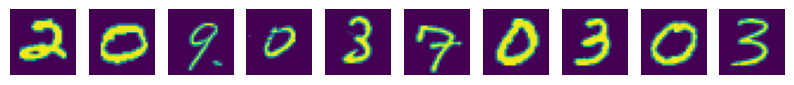

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))
for i in range (10):
  print(predicted_labels[i], end = '          ')
  axes[i].imshow(dataset[i][0].numpy().reshape(28,28))
  axes[i].axis('off')

In [ ]:
# Сохранение DataFrame в CSV файл
submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/УИРС/Conv_submission.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/УИРС/Conv_submission.csv')
df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
